In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
import h5py
import numpy as np

h5_path = "/content/drive/MyDrive/Codigos_Fallos/Carpeta_Dataset/dataset_sync.h5"

X_vib, X_acoustic, X_temp, y = [], [], [], []

with h5py.File(h5_path, "r") as f:
    for cond in f.keys():
        g = f[cond]
        try:
            # Vibración
            v1 = g["vibration"]["accel_1"]["signal_sync"][:].astype(np.float32)
            v2 = g["vibration"]["accel_2"]["signal_sync"][:].astype(np.float32)
            if len(v1) == 0 or len(v2) == 0:
                continue
            min_len_vib = min(len(v1), len(v2))
            vib = np.stack([v1[:min_len_vib], v2[:min_len_vib]], axis=0)

            # Acústico
            if "acoustic" in g:
                a = g["acoustic"]["signal_sync"][:].astype(np.float32)
                if len(a) == 0:
                    a = np.zeros(min_len_vib, dtype=np.float32)
            else:
                a = np.zeros(min_len_vib, dtype=np.float32)

            # Temperatura
            if "temperature" in g["external"]:
                tmp = g["external"]["temperature"]["signal_sync"][:].astype(np.float32)
                if len(tmp) == 0:
                    tmp = np.zeros(min_len_vib, dtype=np.float32)
            else:
                tmp = np.zeros(min_len_vib, dtype=np.float32)

            # Ajustar longitud mínima
            min_len_group = min(min_len_vib, len(a), len(tmp))
            vib = vib[:, :min_len_group]
            a   = a[:min_len_group]
            tmp = tmp[:min_len_group]

            # Guardar
            X_vib.append(vib)
            X_acoustic.append(a)
            X_temp.append(tmp)
            y.append(cond)

        except Exception as e:
            print(f"Saltando {cond} por error: {e}")

# Recorte global
min_len_all = min(
    min(x.shape[1] for x in X_vib),
    min(len(a) for a in X_acoustic),
    min(len(t) for t in X_temp)
)

X_vib      = np.array([x[:, :min_len_all] for x in X_vib])
X_acoustic = np.array([a[:min_len_all] for a in X_acoustic])
X_temp     = np.array([t[:min_len_all] for t in X_temp])
y          = np.array(y)

print("Shapes después de recorte global:")
print("Vib:", X_vib.shape)
print("Acoustic:", X_acoustic.shape)
print("Temp:", X_temp.shape)
print("y:", y.shape)


Shapes después de recorte global:
Vib: (45, 2, 1536000)
Acoustic: (45, 1536000)
Temp: (45, 1536000)
y: (45,)


In [12]:
# Mapping clases
unique_labels = sorted(set(y))
label_map = {name: idx for idx, name in enumerate(unique_labels)}
y_idx = np.array([label_map[name] for name in y])

num_classes = len(unique_labels)
print("Número de clases:", num_classes)

# Expandir dimensiones
X_acoustic = X_acoustic[:, np.newaxis, :]   # (N,1,L)
X_temp     = X_temp[:, np.newaxis, :]       # (N,1,L)

# Concatenar vib (2) + ac (1) = (3,L) → entrada CNN
X_base = np.concatenate([X_vib, X_acoustic], axis=1)

# Normalización z-score
mean_base = X_base.mean(axis=(0,2), keepdims=True)
std_base  = X_base.std(axis=(0,2), keepdims=True) + 1e-8
X_base = (X_base - mean_base) / std_base

mean_temp = X_temp.mean(axis=(0,2), keepdims=True)
std_temp  = X_temp.std(axis=(0,2), keepdims=True) + 1e-8
X_temp = (X_temp - mean_temp) / std_temp

print("X_base:", X_base.shape, "X_temp:", X_temp.shape)


Número de clases: 45
X_base: (45, 3, 1536000) X_temp: (45, 1, 1536000)


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FuzzyLayerModulator(nn.Module):
    def __init__(self, n_sets=3, feat_dim=32):
        super(FuzzyLayerModulator, self).__init__()
        self.n_sets = n_sets
        self.centers = nn.Parameter(torch.linspace(-1, 1, n_sets))
        self.sigmas  = nn.Parameter(torch.ones(n_sets) * 0.5)

        # Bloque conv para procesar membresías
        self.conv = nn.Sequential(
            nn.Conv1d(n_sets, 16, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(16)
        )

        # Dos cabezas: γ y β
        self.fc_gamma = nn.Linear(16*16, feat_dim)
        self.fc_beta  = nn.Linear(16*16, feat_dim)

    def membership(self, x, c, s):
        return torch.exp(-0.5 * ((x - c) / s) ** 2)

    def forward(self, x):
        """
        x: (B,1,L) → temperatura ya normalizada
        """
        B, _, L = x.shape
        sets = []
        for j in range(self.n_sets):
            mu = self.membership(x.squeeze(1), self.centers[j], self.sigmas[j])  # (B,L)
            sets.append(mu.unsqueeze(1))
        fuzzy_out = torch.cat(sets, dim=1)        # (B,n_sets,L)
        feat = self.conv(fuzzy_out).flatten(1)    # (B,256)

        gamma = self.fc_gamma(feat)  # (B,feat_dim)
        beta  = self.fc_beta(feat)   # (B,feat_dim)
        return gamma, beta


In [14]:
class CNN_FuzzyTempMod(nn.Module):
    def __init__(self, num_classes):
        super(CNN_FuzzyTempMod, self).__init__()

        # Bloque CNN inicial
        self.conv1 = nn.Sequential(
            nn.Conv1d(3, 16, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )

        # Bloque CNN intermedio (será modulado)
        self.conv2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )

        # Pool global
        self.pool = nn.AdaptiveAvgPool1d(64)

        # Fuzzy con temperatura → genera γ y β para 32 canales
        self.fuzzy_mod = FuzzyLayerModulator(n_sets=3, feat_dim=32)

        # Clasificador
        self.fc = nn.Sequential(
            nn.Linear(32*64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x_base, x_temp):
        # x_base: vib+acoustic (B,3,L)
        # x_temp: temperatura (B,1,L)

        out = self.conv1(x_base)   # (B,16,L/2)
        out = self.conv2(out)      # (B,32,L/4)

        # Fuzzy → γ y β
        gamma, beta = self.fuzzy_mod(x_temp)   # (B,32)
        gamma = gamma.unsqueeze(-1)            # (B,32,1)
        beta  = beta.unsqueeze(-1)             # (B,32,1)

        # Modulación tipo FiLM
        out = gamma * out + beta

        out = self.pool(out)
        feat = out.flatten(1)
        return self.fc(feat)


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class MotorDatasetTemp(Dataset):
    def __init__(self, X_base, X_temp, y, window_size=2048, step=2048):
        self.X_base = X_base
        self.X_temp = X_temp
        self.y = y
        self.window_size = window_size
        self.step = step
        self.indices = []

        for i in range(len(X_base)):
            n = X_base[i].shape[1]
            for start in range(0, n - window_size + 1, step):
                end = start + window_size
                self.indices.append((i, start, end))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample_idx, start, end = self.indices[idx]
        x_base = self.X_base[sample_idx][:, start:end]   # (3, win)
        x_temp = self.X_temp[sample_idx][:, start:end]   # (1, win)
        label  = self.y[sample_idx]
        return (
            torch.tensor(x_base, dtype=torch.float32),
            torch.tensor(x_temp, dtype=torch.float32),
            torch.tensor(label, dtype=torch.long),
        )

# Crear dataset
dataset = MotorDatasetTemp(X_base, X_temp, y_idx, window_size=2048, step=2048)

# Split train/val
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Ventanas totales:", len(dataset))
print("Train:", len(train_dataset), "Val:", len(val_dataset))


Ventanas totales: 33750
Train: 27000 Val: 6750


In [18]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_FuzzyTempMod(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 200
patience = 15
best_val_acc = 0.0
epochs_no_improve = 0
best_model_path = "best_model_fuzzy_temp_mod.pth"

for epoch in range(num_epochs):
    # ---- Entrenamiento ----
    model.train()
    train_loss, train_correct, total = 0, 0, 0
    for x_base, x_temp, y_batch in train_loader:
        x_base, x_temp, y_batch = x_base.to(device), x_temp.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_base, x_temp)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_base.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc = train_correct / total
    train_loss /= total

    # ---- Validación ----
    model.eval()
    val_loss, val_correct, total_val = 0, 0, 0
    with torch.no_grad():
        for x_base, x_temp, y_batch in val_loader:
            x_base, x_temp, y_batch = x_base.to(device), x_temp.to(device), y_batch.to(device)
            outputs = model(x_base, x_temp)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * x_base.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_acc = val_correct / total_val
    val_loss /= total_val

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # ---- Guardar mejor modelo ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Mejor modelo guardado en epoch {epoch+1} con val_acc={val_acc:.4f}")
    else:
        epochs_no_improve += 1

    # ---- Early stopping ----
    if epochs_no_improve >= patience:
        print("⏹ Early stopping activado")
        break

print(f"Entrenamiento finalizado. Mejor val_acc={best_val_acc:.4f}, modelo en {best_model_path}")


Epoch [1/200] Train Loss: 1.2878, Acc: 0.5355 Val Loss: 0.5330, Acc: 0.7861
✅ Mejor modelo guardado en epoch 1 con val_acc=0.7861
Epoch [2/200] Train Loss: 0.7787, Acc: 0.6758 Val Loss: 0.5303, Acc: 0.7673
Epoch [3/200] Train Loss: 0.7043, Acc: 0.6980 Val Loss: 0.4037, Acc: 0.8264
✅ Mejor modelo guardado en epoch 3 con val_acc=0.8264
Epoch [4/200] Train Loss: 0.6596, Acc: 0.7171 Val Loss: 0.4542, Acc: 0.8204
Epoch [5/200] Train Loss: 0.6349, Acc: 0.7252 Val Loss: 0.3863, Acc: 0.8742
✅ Mejor modelo guardado en epoch 5 con val_acc=0.8742
Epoch [6/200] Train Loss: 0.6081, Acc: 0.7385 Val Loss: 0.3803, Acc: 0.8646
Epoch [7/200] Train Loss: 0.6059, Acc: 0.7439 Val Loss: 0.3683, Acc: 0.8719
Epoch [8/200] Train Loss: 0.5977, Acc: 0.7445 Val Loss: 0.3854, Acc: 0.8227
Epoch [9/200] Train Loss: 0.5853, Acc: 0.7524 Val Loss: 0.3801, Acc: 0.8474
Epoch [10/200] Train Loss: 0.5607, Acc: 0.7601 Val Loss: 0.3341, Acc: 0.8831
✅ Mejor modelo guardado en epoch 10 con val_acc=0.8831
Epoch [11/200] Train L

Cohen's Kappa (global): 0.9171


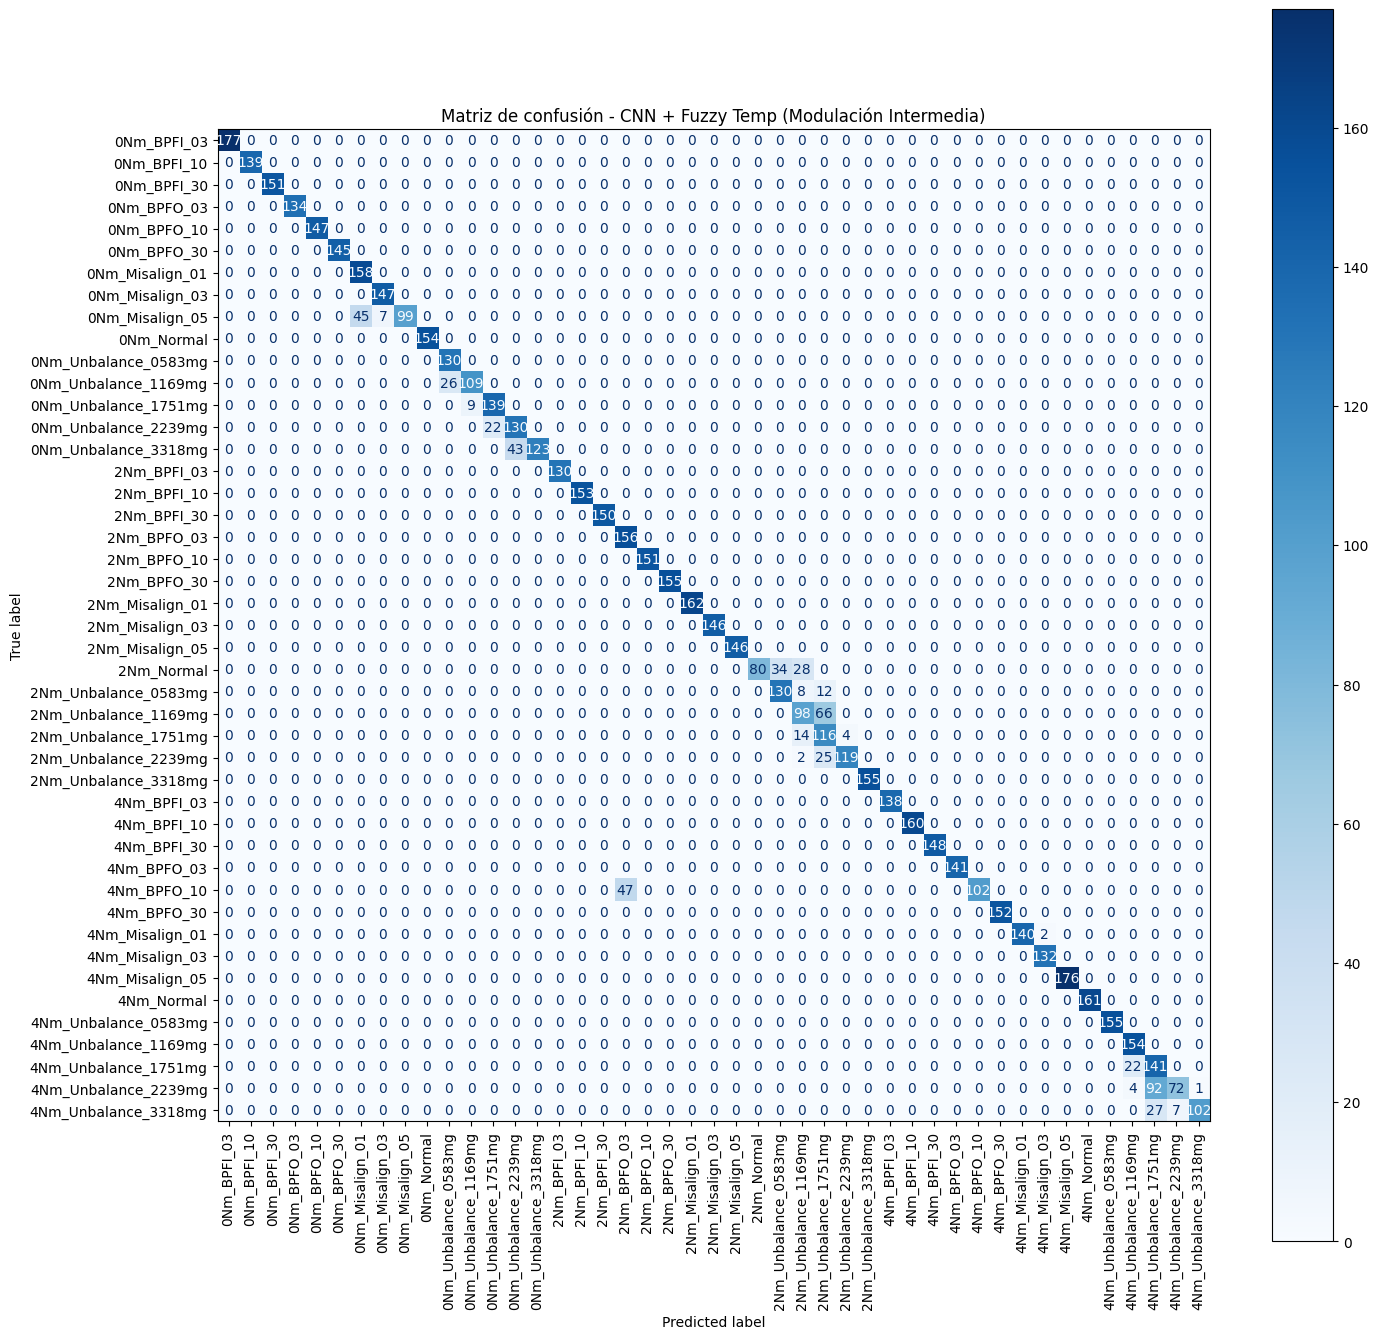

In [19]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# =====================
# Cargar mejor modelo
# =====================
best_model = CNN_FuzzyTempMod(num_classes).to(device)
best_model.load_state_dict(torch.load("best_model_fuzzy_temp_mod.pth", map_location=device))
best_model.eval()

all_labels, all_preds = [], []

# =====================
# Evaluación en validación
# =====================
with torch.no_grad():
    for x_base, x_temp, y_batch in val_loader:
        x_base, x_temp, y_batch = x_base.to(device), x_temp.to(device), y_batch.to(device)
        outputs = best_model(x_base, x_temp)
        preds = outputs.argmax(dim=1)

        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# =====================
# Cohen's Kappa (global)
# =====================
kappa = cohen_kappa_score(all_labels, all_preds)
print(f"Cohen's Kappa (global): {kappa:.4f}")

# =====================
# Matriz de confusión
# =====================
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

fig, ax = plt.subplots(figsize=(16, 16))
disp.plot(ax=ax, cmap="Blues", colorbar=True, xticks_rotation=90)
plt.title("Matriz de confusión - CNN + Fuzzy Temp (Modulación Intermedia)")
plt.show()


In [17]:
from google.colab import files
files.download(best_model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
print(f"Entrenamiento finalizado. Mejor val_acc={best_val_acc:.4f}, modelo en {best_model_path}")

# Descargar automáticamente el mejor modelo
from google.colab import files
files.download(best_model_path)


Entrenamiento finalizado. Mejor val_acc=0.9190, modelo en best_model_fuzzy_temp_mod.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>